# Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv('car_sales_data.csv')
df.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [4]:
df.isna().sum()

Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
dtype: int64

# Feature analysis

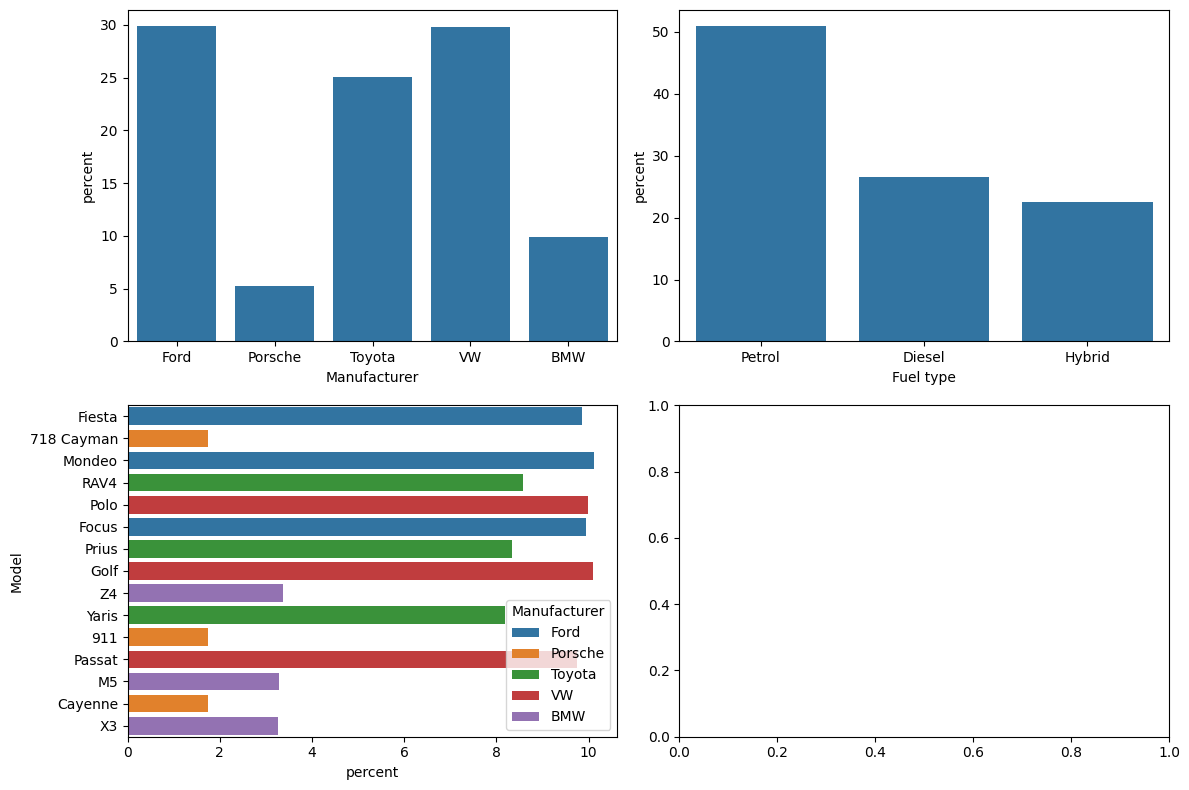

In [5]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

sns.countplot(data=df, x='Manufacturer', stat='percent', ax=axes[0,0])
sns.countplot(data=df, x='Fuel type', stat='percent', ax=axes[0,1])
sns.countplot(data=df, y='Model', hue='Manufacturer', stat='percent', ax=axes[1,0])
plt.tight_layout()
plt.show()

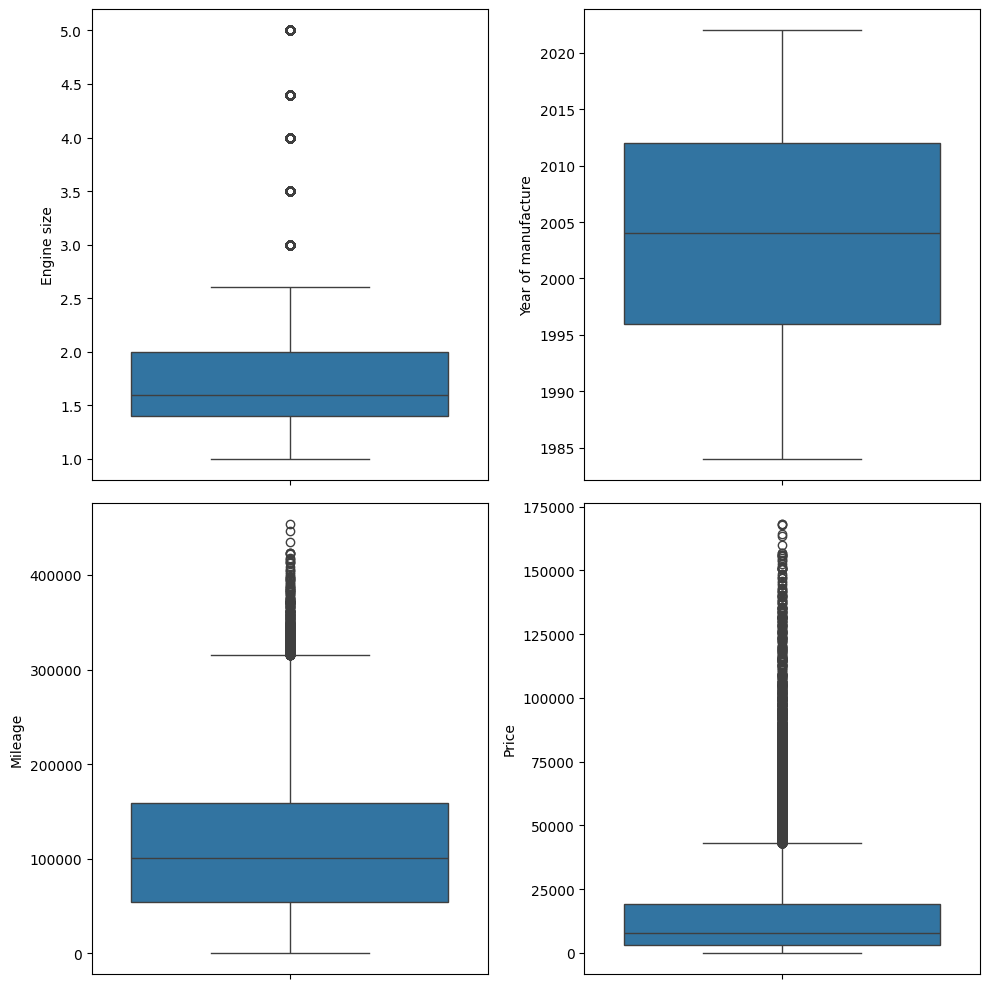

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

sns.boxplot(data=df, y='Engine size', ax=axes[0,0])
sns.boxplot(data=df, y='Year of manufacture', ax=axes[0,1])
sns.boxplot(data=df, y='Mileage', ax=axes[1,0])
sns.boxplot(data=df, y='Price', ax=axes[1,1])
plt.tight_layout()
plt.show()

In [7]:
print(f"Engine outliers: {df[df['Engine size'] >= 3.0].shape[0]}")
print(f"Mileage outliers: {df[df['Mileage'] > 300000].shape[0]}")
print(f"Price outliers: {df[df['Price'] >= 50000].shape[0]}")

Engine outliers: 3951
Mileage outliers: 608
Price outliers: 1739


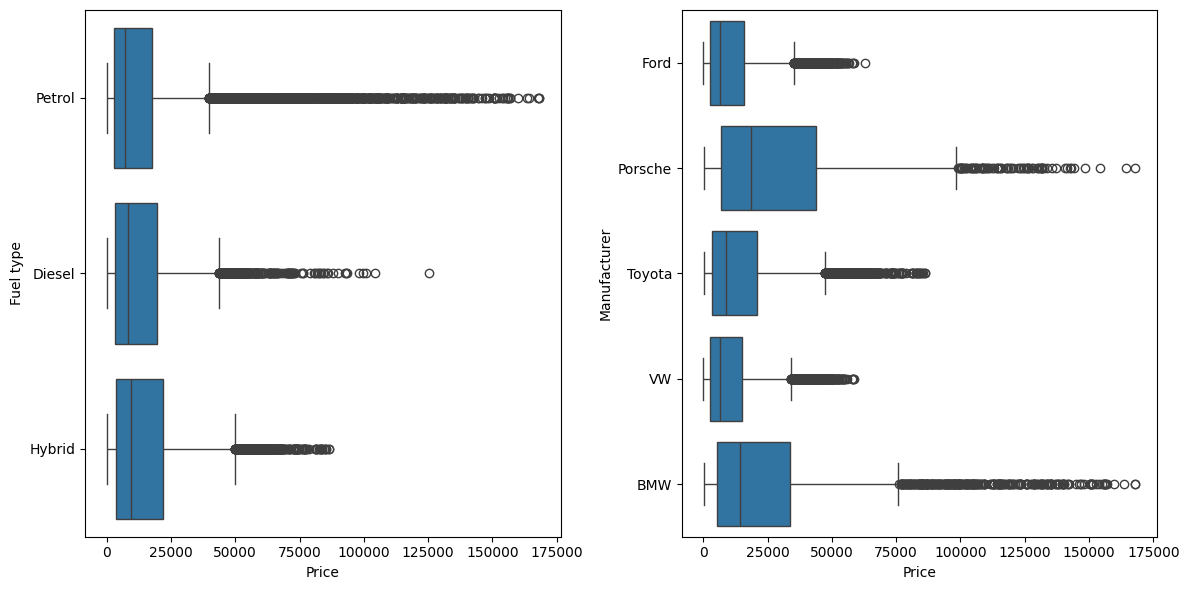

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.boxplot(data=df, x='Price', y='Fuel type', ax=axes[0])
sns.boxplot(data=df, x='Price', y='Manufacturer', ax=axes[1])
plt.tight_layout()
plt.show()

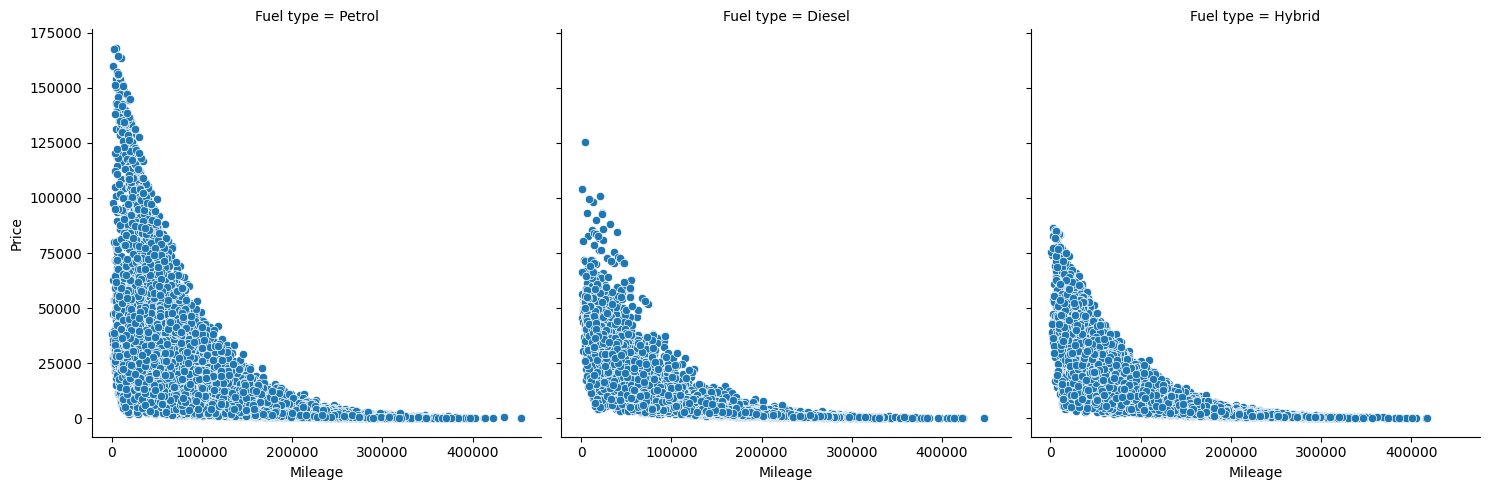

In [9]:
sns.relplot(data=df, x='Mileage', y='Price', col='Fuel type')

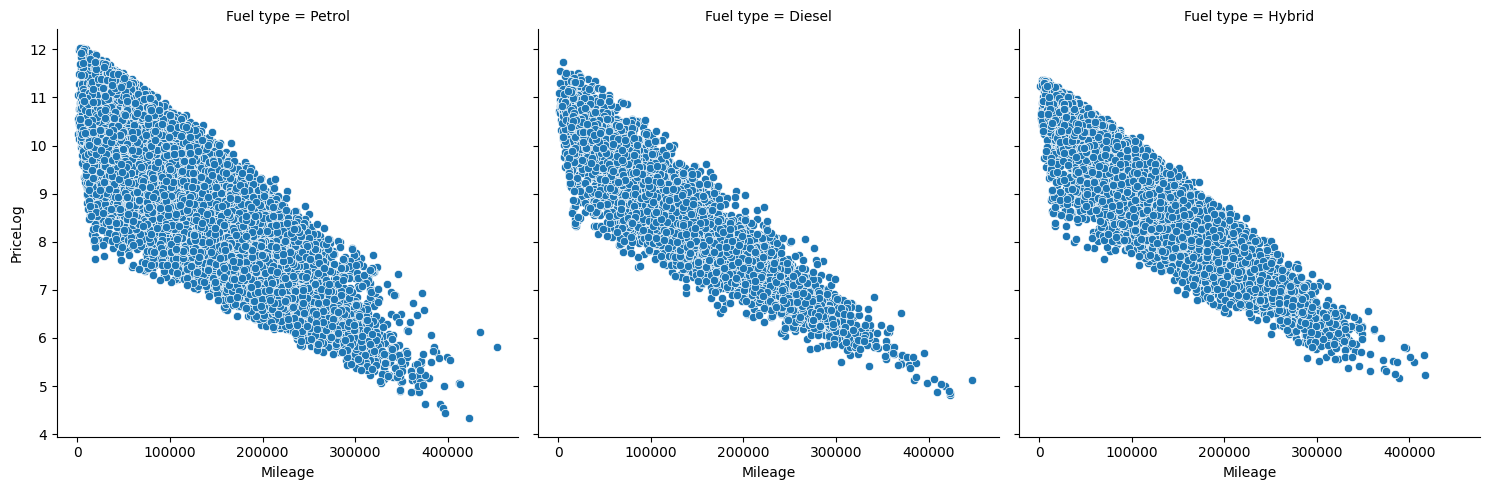

In [10]:
df['PriceLog'] = np.log(df['Price'])
sns.relplot(data=df, x='Mileage', y='PriceLog', col='Fuel type')

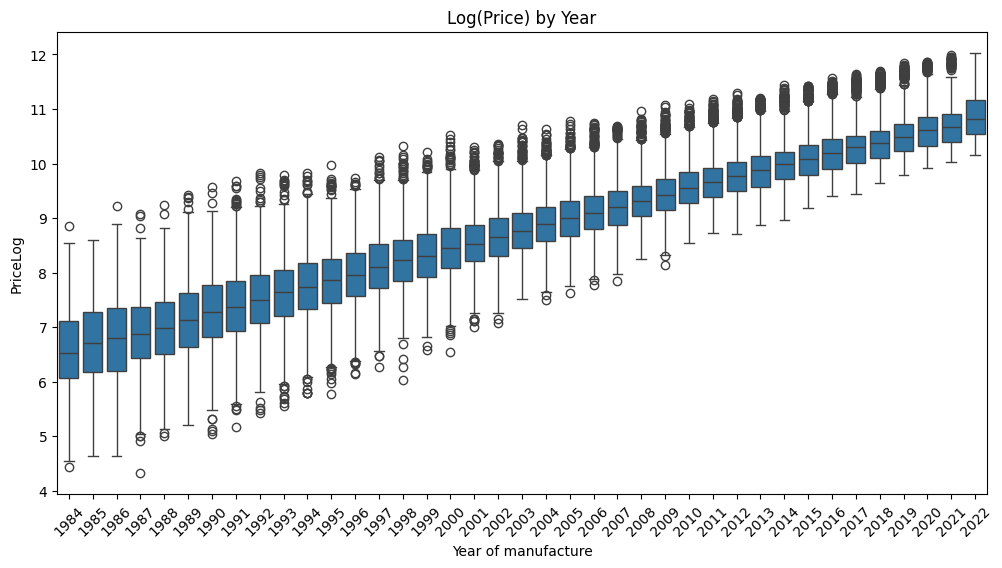

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Year of manufacture', y='PriceLog')
plt.xticks(rotation=45)
plt.title('Log(Price) by Year')
plt.show()

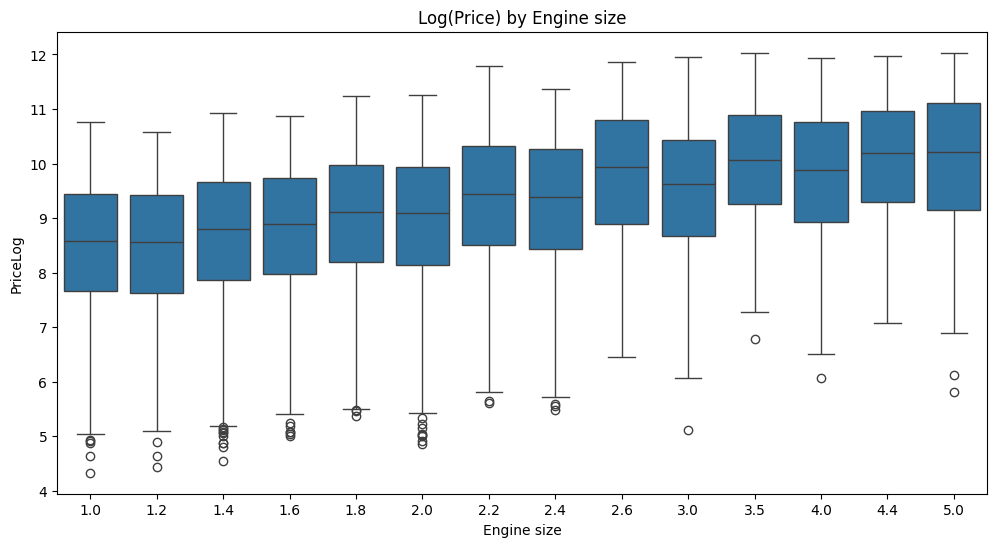

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Engine size', y='PriceLog')
plt.title('Log(Price) by Engine size')
plt.show()

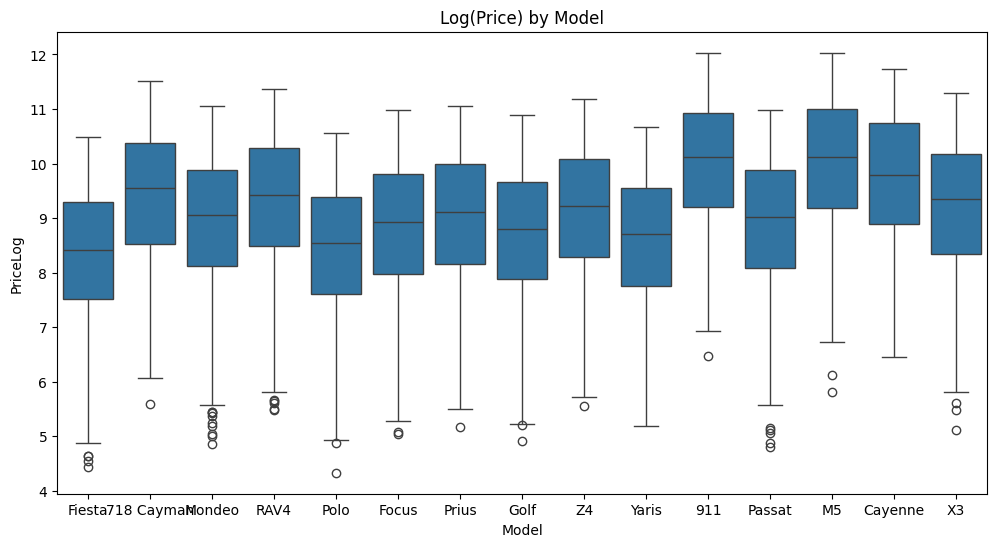

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Model', y='PriceLog')
plt.title('Log(Price) by Model')
plt.show()

We will predict log(Price) and then the price transform back.

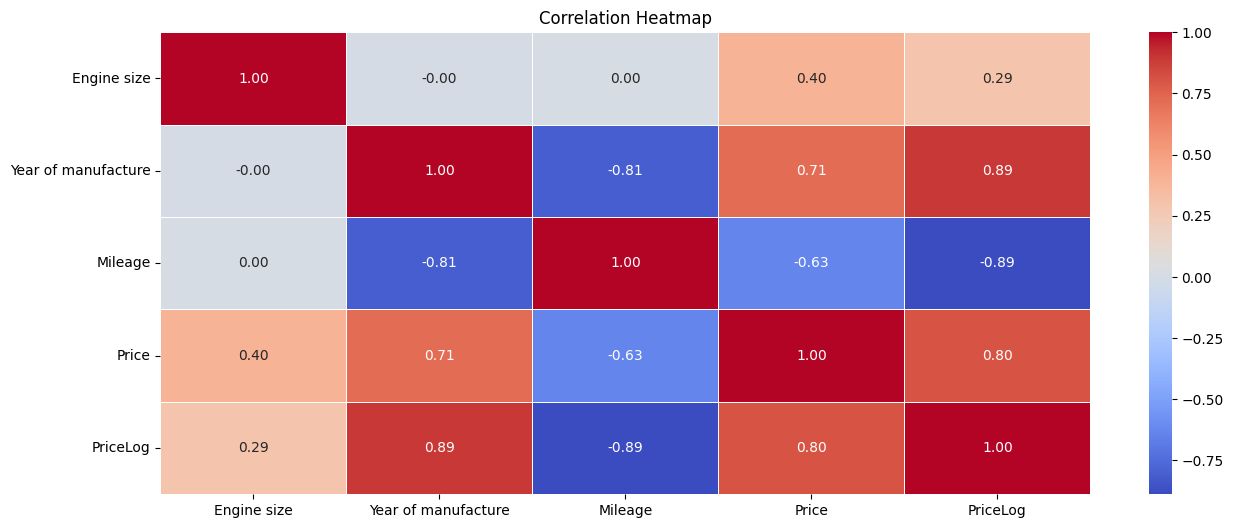

In [14]:
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

# Linear Regression Model

In [15]:
X = df.drop(['Price', 'PriceLog'], axis=1)
y = df['PriceLog']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder

categorical_features = ['Fuel type', 'Model', 'Manufacturer']
preprocessor = ColumnTransformer(
    transformers=[
        ('mileage', RobustScaler(), ['Mileage']),
        ('year', MinMaxScaler(), ['Year of manufacture']),
        ('engine', RobustScaler(), ['Engine size']),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ])
preprocessor.set_output(transform='pandas')

,transformers,"[('mileage', ...), ('year', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


In [17]:
import sklearn.metrics as skm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

Test p-value for each column.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_df = preprocessor.fit_transform(X_train)
X_df = sm.add_constant(X_df)

# Fit model
model = sm.OLS(y_train, X_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PriceLog   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.103e+06
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:44:44   Log-Likelihood:                 60825.
No. Observations:               40000   AIC:                        -1.216e+05
Df Residuals:                   39980   BIC:                        -1.214e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.8790      0.001   6682.583      0.000       4.878       4.880
mileage__Mileage             -0.8455      0.001  -1295.675      0.000      -0.847      -0.844
year__Year of manufacture     2.4231      0.002   1372.413      0.000       2.420       2.427
engine__Engine size           0.1626      0.001    319.711      0.000       0.162       0.164
cat__Fuel type_Diesel         1.5982      0.001   2383.172      0.000       1.597       1.600
cat__Fuel type_Hybrid         1.7322      0.001   2185.568      0.000       1.731       1.734
cat__Fuel type_Petrol         1.5486      0.001   3019.357      0.000       1.548       1.550
cat__Model_718 Cayman         0.1848      0.002    111.269      0.000       0.181       0.188
cat__Model_911                0.7679      0.002    458.246      0.000       0.765       0.771
cat__Model_Cayenne            0.3170      0.002    182.580      0.000       0.314       0.320
cat__Model_Fiesta             0.0067      0.001      8.088      0.000       0.005       0.008
cat__Model_Focus              0.4023      0.001    572.551      0.000       0.401       0.404
cat__Model_Golf               0.2520      0.001    357.717      0.000       0.251       0.253
cat__Model_M5                 0.5760      0.002    314.801      0.000       0.572       0.580
cat__Model_Mondeo             0.4074      0.001    513.388      0.000       0.406       0.409
cat__Model_Passat             0.4803      0.001    606.897      0.000       0.479       0.482
cat__Model_Polo               0.0674      0.001     87.440      0.000       0.066       0.069
cat__Model_Prius              0.3324      0.001    372.462      0.000       0.331       0.334
cat__Model_RAV4               0.5199      0.001    613.811      0.000       0.518       0.522
cat__Model_X3                 0.2723      0.001    204.470      0.000       0.270       0.275
cat__Model_Yaris              0.0587      0.001     66.851      0.000       0.057       0.060
cat__Model_Z4                 0.2340      0.001    183.069      0.000       0.231       0.236
cat__Manufacturer_BMW         1.0822      0.001   1208.152      0.000       1.080       1.084
cat__Manufacturer_Ford        0.8165      0.001   1506.980      0.000       0.815       0.818
cat__Manufacturer_Porsche     1.2697      0.001   1301.633      0.000       1.268       1.272
cat__Manufacturer_Toyota      0.9110      0.001   1322.767      0.000       0.910       0.912
cat__Manufacturer_VW          0.7997      0.001   1563.295      0.000       0.799       0.801
==============================================================================
Omnibus:                     5961.020   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11599.446
Skew:                     

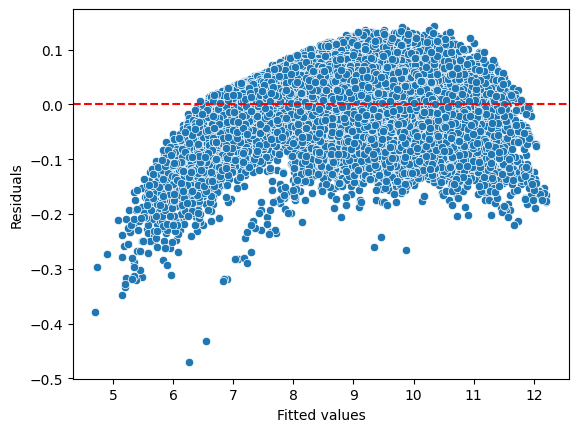

In [20]:
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [21]:
X_test_df = preprocessor.transform(X_test)
X_test_df = sm.add_constant(X_test_df)
y_pred_log = model.predict(X_test_df)

In [22]:
y_pred_price = np.exp(y_pred_log)
y_true_price = np.exp(y_test)

In [23]:
mse = skm.mean_squared_error(y_true_price, y_pred_price)
rmse = np.sqrt(mse)
mae = skm.mean_absolute_error(y_true_price, y_pred_price)
r2 = skm.r2_score(y_true_price, y_pred_price)
print(f"MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.2f}")

MSE=2290816.63, RMSE=1513.54, MAE=628.61, R^2=0.99


# Decision Tree Regression Model

In [24]:
X = df.drop(['Price', 'PriceLog'], axis=1)
y = df['Price']

In [25]:
X = pd.get_dummies(data=X, columns=categorical_features, drop_first=False)
X.head()

,Engine size,Year of manufacture,Mileage,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_Petrol,Model_718 Cayman,Model_911,Model_Cayenne,Model_Fiesta,...,Model_Prius,Model_RAV4,Model_X3,Model_Yaris,Model_Z4,Manufacturer_BMW,Manufacturer_Ford,Manufacturer_Porsche,Manufacturer_Toyota,Manufacturer_VW
0,1.0,2002,127300,False,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,4.0,2016,57850,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,1.6,2014,39190,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,1.8,1988,210814,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,1.0,2006,127869,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model_tree = DecisionTreeRegressor(max_depth=15, random_state=42)
model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)

In [29]:
mse = skm.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = skm.mean_absolute_error(y_test, y_pred)
r2 = skm.r2_score(y_test, y_pred)
print(f"MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.2f}")

MSE=1247667.37, RMSE=1116.99, MAE=596.73, R^2=1.00


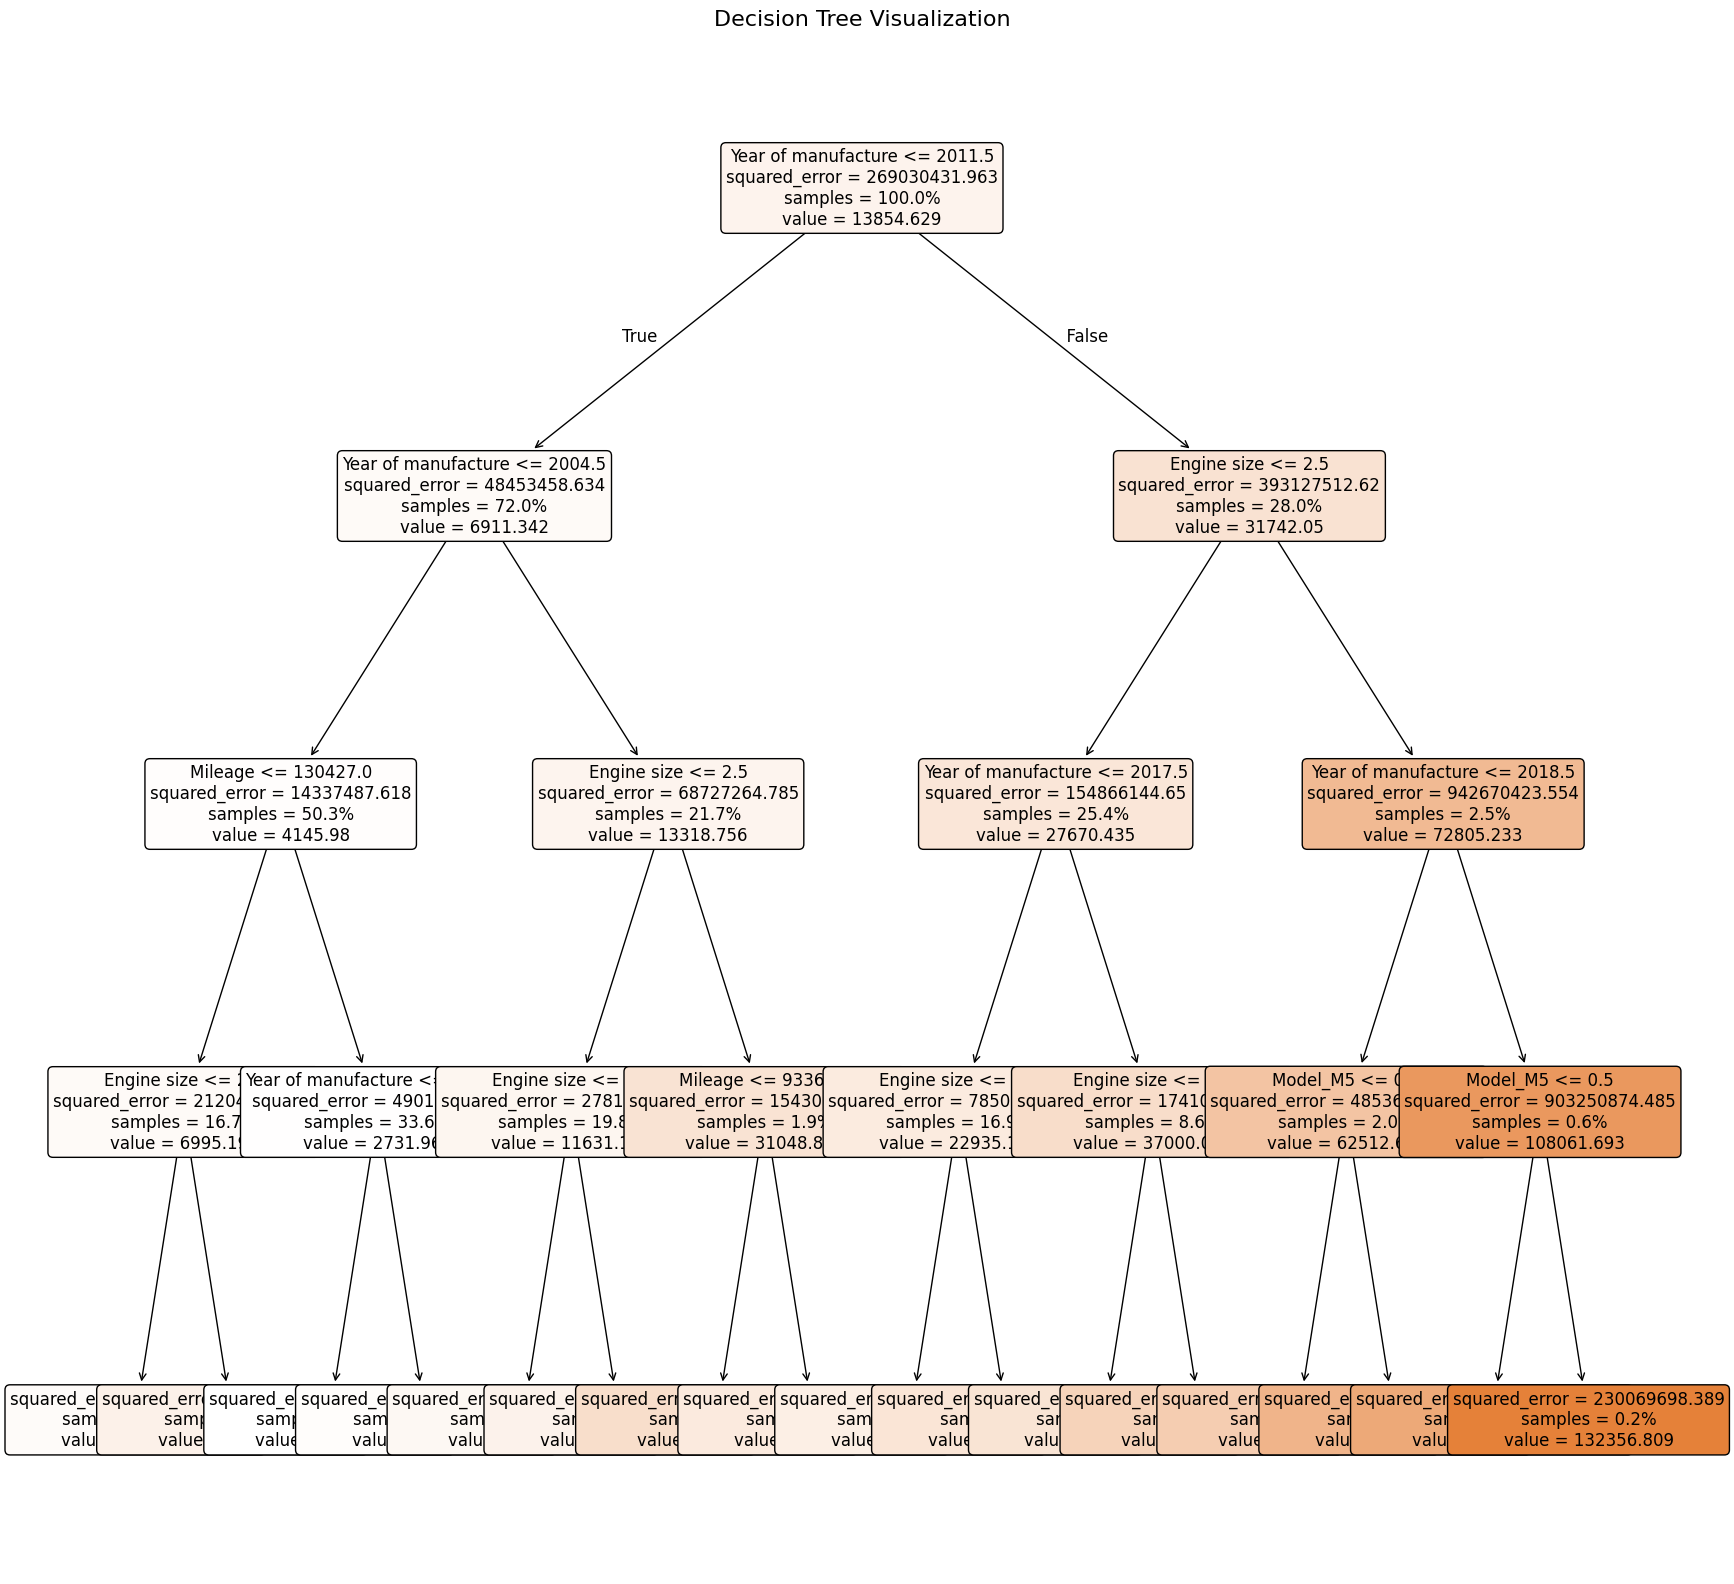

In [30]:
from sklearn.tree import plot_tree

model_tree = DecisionTreeRegressor(max_depth=4, random_state=42)
model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)

plt.figure(figsize=(20, 20))
plot_tree(model_tree, 
          feature_names=X_train.columns, 
          filled=True,                   
          rounded=True,          
          fontsize=12,
          proportion=True)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()